In [1]:
import numpy as np
import pandas as pd

from polara import get_movielens_data
from polara.lib.earlystopping import early_stopping_callback

from dataprep import split_data, assign_positions
from model import seqtf_model_build, tf_scoring
from evaluation import downvote_seen_items, model_evaluate, topn_recommendations

# Preparing Data

In [2]:
mldata = get_movielens_data('ml-1m.zip', include_time=True)
mldata.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
train_pack, valid_pack, test_pack = split_data(mldata, time_q=0.9)

Filtered 113 invalid observations.


In [4]:
n_pos = 200

training_data = assign_positions(train_pack[0], n_pos)
testset_valid = assign_positions(valid_pack[0], n_pos)
testset = assign_positions(test_pack[0], n_pos)

In [5]:
training_data.head()

,userid,movieid,rating,timestamp,pos
3805,0,786,5,978128786,130
3819,0,1789,2,978128821,131
3785,0,289,4,978128821,132
3832,0,1545,3,978128865,133
3816,0,3290,1,978128865,134


In [6]:
testset_valid.head()

,userid,movieid,rating,timestamp,pos
31,1,2915,4,978300019,149
27,1,1544,4,978300055,150
22,1,1156,5,978300055,151
37,1,937,5,978300055,152
24,1,2104,3,978300103,153


In [7]:
testset.head()

,userid,movieid,rating,timestamp,pos
31,1,2915,4,978300019,148
27,1,1544,4,978300055,149
22,1,1156,5,978300055,150
37,1,937,5,978300055,151
24,1,2104,3,978300103,152


# Model

In [8]:
data_index = train_pack[1]
data_description = dict(
    userid = data_index['userid'].name,
    itemid = data_index['itemid'].name,
    positionid = 'pos',
    n_users = len(data_index['userid']),
    n_items = len(data_index['itemid']),
    n_pos = n_pos
)
data_description

{'userid': 'userid',
 'itemid': 'movieid',
 'positionid': 'pos',
 'n_users': 4831,
 'n_items': 3635,
 'n_pos': 200}

In [9]:
config = {
    "mlrank": (30, 25, 5),
    "n_pos": n_pos,
    "max_iters": 4,
    "update_order": (2, 1, 0),
    "growth_tol": 1e-6,
    "seed": 42
}

In [10]:
tf_params_old = seqtf_model_build(config, training_data, data_description)

Step 0 growth of the core: 1.0
Step 1 growth of the core: 0.260121144975013
Step 2 growth of the core: 0.07896051641741418
Step 3 growth of the core: 0.04049245048013042


# Tuning

In [11]:
def tf_evaluator(testset, holdout, data_description, core_projected, topn=10):
    def iter_evaluate(core_factors, factors):
        model_params = tuple(factors) + (core_factors,)
        scores = tf_scoring(model_params, testset, data_description, core_projected=core_projected) 
        downvote_seen_items(scores, testset, data_description)
        top_recs = topn_recommendations(scores, topn=topn)
        hr, *_ = model_evaluate(top_recs, holdout, data_description)
        return hr
    return iter_evaluate

class TFParamStore:
    core = None
    factors = None
    def __call__(self, core_factors, factors):
        self.core = core_factors
        self.factors = factors

In [12]:
evaluator = tf_evaluator(testset_valid, valid_pack[1], data_description, core_projected=True)
optimal_params = TFParamStore()
early_stopper = early_stopping_callback(evaluator, max_fails=2, param_store=optimal_params)

params = seqtf_model_build(
    {**config, **{'max_iters': 15}},
    training_data,
    data_description,
    iter_callback=early_stopper
)

Step 0 metric score: 0.02990325417766051
Step 1 metric score: 0.044854881266490766
Step 2 metric score: 0.051011433597185574
Step 3 metric score: 0.06068601583113457
Step 4 metric score: 0.05804749340369393
Step 5 metric score: 0.05716798592788039
Metric no longer improves. Best score 0.06068601583113457, attained in 4 iterations.


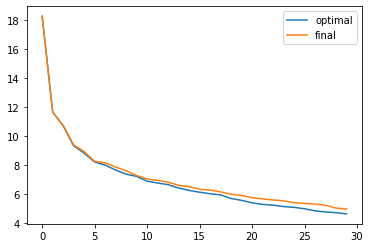

In [13]:
ax = pd.Series(optimal_params.core[0]).plot(label='optimal')
pd.Series(params[-1][0]).plot(ax=ax, label='final')
ax.legend();

In [14]:
evaluator = tf_evaluator(testset_valid, valid_pack[1], data_description, core_projected=False)
early_stopper_no_proj = early_stopping_callback(evaluator, max_fails=2, param_store=None)

params = seqtf_model_build(
    {**config, **{'max_iters': 15}},
    training_data,
    data_description,
    iter_callback=early_stopper_no_proj
)

Step 0 metric score: 0.02198768689533861
Step 1 metric score: 0.027264731750219876
Step 2 metric score: 0.03518029903254178
Step 3 metric score: 0.04309586631486367
Step 4 metric score: 0.04925241864555849
Step 5 metric score: 0.056288478452066845
Step 6 metric score: 0.05804749340369393
Step 7 metric score: 0.06068601583113457
Step 8 metric score: 0.06244503078276165
Step 9 metric score: 0.06244503078276165
Step 10 metric score: 0.06068601583113457
Metric no longer improves. Best score 0.06244503078276165, attained in 9 iterations.


In [15]:
evaluator = tf_evaluator(testset_valid, valid_pack[1], data_description, core_projected=False)
early_stopper_012 = early_stopping_callback(evaluator, max_fails=2, param_store=None)

params = seqtf_model_build(
    {**config, **{'max_iters': 15, "update_order": (0, 1, 2)}},
    training_data,
    data_description,
    iter_callback=early_stopper_012
)

Step 0 metric score: 0.028144239226033423
Step 1 metric score: 0.047493403693931395
Step 2 metric score: 0.058927000879507474
Step 3 metric score: 0.05980650835532102
Step 4 metric score: 0.06772207563764292
Step 5 metric score: 0.06860158311345646
Step 6 metric score: 0.06772207563764292
Step 7 metric score: 0.06860158311345646
Metric no longer improves. Best score 0.06860158311345646, attained in 6 iterations.


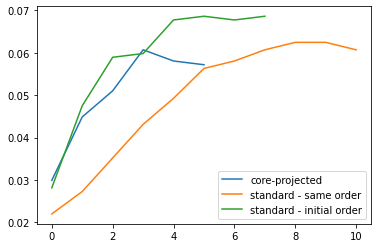

In [16]:
ax = pd.Series(early_stopper.history).plot(label='core-projected')
pd.Series(early_stopper_no_proj.history).plot(ax=ax, label='standard - same order')
pd.Series(early_stopper_012.history).plot(ax=ax, label='standard - initial order')
ax.legend();